In [70]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [74]:
def rank(a, p):
    return np.argsort(np.hstack((a, p)))[:,0]

a = np.random.uniform(0, 20, (10000, 1))
p = np.random.uniform(0, 20, (10000, 5))
r = np.reshape(rank(a, p), (10000, 1))
x1 = np.hstack((a, p, r))
y1 = (r == 0).astype(int).ravel()


In [75]:
regr = linear_model.LogisticRegression()
regr.fit(x1, y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

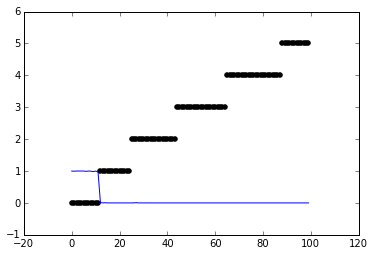

In [81]:
x1_sort = np.sort(x1[0:100,].view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, 100), x1_sort[0:100,6], color='black')
plt.plot(np.arange(0, 100), regr.predict_proba(x1_sort[0:100,])[:,1], color='blue', linewidth=1)

plt.show()

In [77]:
regr.predict_proba(x1_sort[0:100,])[:,0]

array([  4.75675425e-04,   5.64676535e-03,   6.16576561e-06,
         9.14063806e-06,   3.20723305e-04,   2.68575008e-06,
         9.69929962e-03,   1.94460392e-05,   4.22175003e-03,
         1.80562785e-02,   1.24980828e-03,   2.69667934e-02,
         9.90338481e-01,   9.98069122e-01,   9.94317831e-01,
         9.99747879e-01,   9.99996214e-01,   9.99998188e-01,
         9.99942095e-01,   9.99999459e-01,   9.99999649e-01,
         9.99993566e-01,   9.99990214e-01,   9.99998678e-01,
         9.99999864e-01,   9.99990555e-01,   9.98599972e-01,
         9.91649943e-01,   9.99842961e-01,   9.99963784e-01,
         9.99995335e-01,   9.99999210e-01,   9.99481306e-01,
         9.99559483e-01,   9.99991191e-01,   9.99999898e-01,
         9.99999962e-01,   9.99999998e-01,   9.99893773e-01,
         9.99999631e-01,   9.99999614e-01,   9.99999996e-01,
         1.00000000e+00,   9.99999998e-01,   9.99999864e-01,
         9.99997151e-01,   9.99999484e-01,   9.99999997e-01,
         9.99999814e-01,